# Importing Data and Libraries
---

In [1]:
import os
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_path_dir = ''
try:
    os.listdir('/kaggle')
    base_path_dir = '/kaggle/input/datathon24playground/datathon-2024-playground'
except:
    base_path_dir = './datathon-2024-playground'
print("Base path:",base_path_dir)

Base path: ./datathon-2024-playground


In [3]:
rename_dict = {
    'id_pengguna': 'user_id',
    'waktu_pendaftaran_akun': 'account_registration_time',
    'waktu_pembelian': 'purchase_time',
    'total_harga_pembelian': 'total_purchase_value',
    'id_perangkat': 'device_id',
    'sumber': 'source',
    'browser': 'browser_type',
    'gender': 'gender',
    'umur': 'age',
    'alamat_IP': 'ip_address',
    'fraud': 'fraud',
    'batas_bawah_alamat_IP': 'ip_lower_bound',
    'batas_atas_alamat_IP': 'ip_upper_bound',
    'negara': 'country'
}

In [4]:
train = pd.read_csv(os.path.join(base_path_dir, 'train.csv'))
train.rename(columns=rename_dict,inplace=True)

test = pd.read_csv(os.path.join(base_path_dir,'test.csv'))
test.rename(columns=rename_dict,inplace=True)

ip = pd.read_csv(os.path.join(base_path_dir,'ip_address_mapping.csv'))
ip.rename(columns=rename_dict,inplace=True)

# Data Description
---
The dataset consists of three files:

### 1. **train.csv** and **test.csv**

| Column Name               | Description                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| `user_id`                 | Unique identifier for each user registered on the e-commerce platform.     |
| `account_registration_time` | The time when the user registered on the e-commerce platform.             |
| `purchase_time`           | The time when the user made a purchase on the e-commerce platform.         |
| `total_purchase_value`    | The transaction value of the purchase made by the user.                    |
| `device_id`               | Unique identifier of the device used by the user to access the platform.   |
| `source`                  | The source or channel through which the user discovered or accessed the platform (e.g., advertisement, organic search, etc.). |
| `browser`                 | The type of browser used by the user to access the e-commerce platform.    |
| `gender`                  | The gender of the user registered on the platform.                         |
| `age`                     | The age of the user registered on the platform.                            |
| `ip_address`              | The IP address used by the user's device when accessing the platform.     |
| `fraud`                   | Classification of the transaction as fraudulent or not (Not available in test.csv). |

---

### 2. **ip_address_mapping.csv**

| Column Name               | Description                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| `ip_lower_bound`          | The lower bound of the IP address range used to determine the user's geographical location. |
| `ip_upper_bound`          | The upper bound of the IP address range used to determine the user's geographical location. |
| `country`                 | The country of origin of the user based on the IP address used to access the platform. |


## Train

In [5]:
train.head(5)

,user_id,account_registration_time,purchase_time,total_purchase_value,device_id,source,browser_type,gender,age,ip_address,fraud
0,286873,6/7/2015 12:58,9/27/2015 16:32,14,DNTIEECGGDXHF,Iklan,Opera,F,38,2.417207e+08,0
1,244392,5/1/2015 15:29,8/27/2015 14:21,11,MECRFNJGDPGOB,SEO,Chrome,M,36,4.172794e+09,0
2,20720,3/29/2015 18:04,6/13/2015 6:50,52,WLTSYVLLASJOZ,SEO,Internet Explorer,M,26,1.113433e+09,0
3,198755,1/29/2015 0:49,2/17/2015 21:49,13,TWGNWOWURZFMY,SEO,Safari,F,38,1.339309e+09,0
4,64996,1/17/2015 19:30,3/1/2015 9:17,23,XMQENRCEILYAJ,Langsung,Safari,F,19,4.602382e+08,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75556 entries, 0 to 75555
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    75556 non-null  int64  
 1   account_registration_time  75556 non-null  object 
 2   purchase_time              75556 non-null  object 
 3   total_purchase_value       75556 non-null  int64  
 4   device_id                  75556 non-null  object 
 5   source                     75556 non-null  object 
 6   browser_type               75556 non-null  object 
 7   gender                     75556 non-null  object 
 8   age                        75556 non-null  int64  
 9   ip_address                 75556 non-null  float64
 10  fraud                      75556 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 6.3+ MB


In [7]:
for col in train.select_dtypes('object'):
    print(f'DESCRIBING: {col}')
    print(train[col].unique())
    print(train[col].nunique())
    print('------------------')

DESCRIBING: account_registration_time
['6/7/2015 12:58' '5/1/2015 15:29' '3/29/2015 18:04' ... '2/18/2015 13:55'
 '4/15/2015 1:21' '1/5/2015 21:56']
70669
------------------
DESCRIBING: purchase_time
['9/27/2015 16:32' '8/27/2015 14:21' '6/13/2015 6:50' ... '5/29/2015 2:41'
 '7/29/2015 7:37' '5/21/2015 5:43']
66979
------------------
DESCRIBING: device_id
['DNTIEECGGDXHF' 'MECRFNJGDPGOB' 'WLTSYVLLASJOZ' ... 'TJYOHNTNXAMYU'
 'VGMIKGWQYPRPI' 'FAYIRBHTCRTHC']
71299
------------------
DESCRIBING: source
['Iklan' 'SEO' 'Langsung']
3
------------------
DESCRIBING: browser_type
['Opera' 'Chrome' 'Internet Explorer' 'Safari' 'Firefox']
5
------------------
DESCRIBING: gender
['F' 'M']
2
------------------


In [8]:
train.describe()

,user_id,total_purchase_value,age,ip_address,fraud
count,75556.000000,75556.000000,75556.000000,7.555600e+04,75556.000000
mean,200306.194994,36.862407,33.124649,2.152027e+09,0.079755
std,115197.966115,18.302404,8.625183,1.247912e+09,0.270916
min,4.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,101157.250000,22.000000,27.000000,1.086566e+09,0.000000
50%,200399.500000,34.000000,33.000000,2.151286e+09,0.000000
75%,299563.250000,49.000000,39.000000,3.243383e+09,0.000000
max,399995.000000,154.000000,73.000000,4.294822e+09,1.000000


## Test

In [9]:
test.head(5)

,user_id,account_registration_time,purchase_time,total_purchase_value,device_id,source,browser_type,gender,age,ip_address
0,28006,2015-06-26 13:27:55,2015-07-13 02:46:13,48,IVHYUSXPDUJUD,SEO,Chrome,M,31,4.268419e+09
1,245189,2015-06-23 15:48:00,2015-09-16 07:26:25,46,UJURCZHQSNBQA,SEO,Firefox,M,34,4.277726e+09
2,58345,2015-06-18 04:14:35,2015-09-21 22:24:59,30,PVWDQUCMMBJXJ,Iklan,Firefox,F,20,1.235071e+09
3,218574,2015-05-19 14:55:18,2015-08-21 00:44:36,29,PMSPHBOFWBTRC,Langsung,Safari,M,25,2.496396e+09
4,49779,2015-04-02 23:35:29,2015-07-08 06:24:47,19,NFGHLAQQPTLVY,Iklan,Chrome,M,38,2.701254e+09


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75556 entries, 0 to 75555
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    75556 non-null  int64  
 1   account_registration_time  75556 non-null  object 
 2   purchase_time              75556 non-null  object 
 3   total_purchase_value       75556 non-null  int64  
 4   device_id                  75556 non-null  object 
 5   source                     75556 non-null  object 
 6   browser_type               75556 non-null  object 
 7   gender                     75556 non-null  object 
 8   age                        75556 non-null  int64  
 9   ip_address                 75556 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 5.8+ MB


In [11]:
for col in test.select_dtypes('object'):
    print(f'DESCRIBING: {col}')
    print(test[col].unique())
    print(test[col].nunique())
    print('------------------')

DESCRIBING: account_registration_time
['2015-06-26 13:27:55' '2015-06-23 15:48:00' '2015-06-18 04:14:35' ...
 '2015-02-18 19:35:42' '2015-06-11 11:25:34' '2015-02-04 03:27:10']
75556
------------------
DESCRIBING: purchase_time
['2015-07-13 02:46:13' '2015-09-16 07:26:25' '2015-09-21 22:24:59' ...
 '2015-06-13 11:32:14' '2015-08-26 16:56:16' '2015-04-21 18:08:33']
75466
------------------
DESCRIBING: device_id
['IVHYUSXPDUJUD' 'UJURCZHQSNBQA' 'PVWDQUCMMBJXJ' ... 'VTNESIHQEDBVT'
 'AFAPNMPPJEHGS' 'EGNGWAPEJUMPO']
70126
------------------
DESCRIBING: source
['SEO' 'Iklan' 'Langsung']
3
------------------
DESCRIBING: browser_type
['Chrome' 'Firefox' 'Safari' 'Internet Explorer' 'Opera']
5
------------------
DESCRIBING: gender
['M' 'F']
2
------------------


In [12]:
test.describe()

,user_id,total_purchase_value,age,ip_address
count,75556.000000,75556.000000,75556.000000,7.555600e+04
mean,200035.886945,37.008338,33.156758,2.152263e+09
std,115540.954156,18.342928,8.610305,1.249090e+09
min,2.000000,9.000000,18.000000,1.058185e+05
25%,100116.750000,22.000000,27.000000,1.085203e+09
50%,199599.500000,35.000000,33.000000,2.159574e+09
75%,300567.250000,49.000000,39.000000,3.243134e+09
max,400000.000000,140.000000,76.000000,4.294850e+09


## IP Address Mapping

In [13]:
ip.head(5)

,ip_lower_bound,ip_upper_bound,country
0,16777216,16777471,Australia
1,16777472,16777727,China
2,16777728,16778239,China
3,16778240,16779263,Australia
4,16779264,16781311,China


In [14]:
ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ip_lower_bound  138846 non-null  int64 
 1   ip_upper_bound  138846 non-null  int64 
 2   country         138846 non-null  object
dtypes: int64(2), object(1)
memory usage: 3.2+ MB


In [15]:
print(ip['country'].nunique())
print(ip['country'].unique())

235
['Australia' 'China' 'Japan' 'Thailand' 'India' 'Malaysia'
 'Korea Republic of' 'Hong Kong' 'Taiwan; Republic of China (ROC)'
 'Philippines' 'Viet Nam' 'France' 'European Union' 'United Kingdom'
 'Italy' 'United Arab Emirates' 'Israel' 'Ukraine' 'Russian Federation'
 'Sweden' 'Kazakhstan' 'Portugal' 'Greece' 'Saudi Arabia' 'Denmark'
 'Spain' 'Iran' 'Norway' 'Germany' 'United States' 'Syrian Arab Republic'
 'Cyprus' 'Czech Republic' 'Switzerland' 'Iraq' 'Netherlands' 'Turkey'
 'Romania' 'Lebanon' 'Hungary' 'Georgia' 'Azerbaijan' 'Austria'
 'Palestina' 'Lithuania' 'Oman' 'Serbia' 'Finland' 'Belgium' 'Bulgaria'
 'Slovenia' 'Moldova Republic of' 'Macedonia' 'Estonia' 'Liechtenstein'
 'Croatia' 'Poland' 'Bosnia and Herzegowina' 'Latvia' 'Jordan'
 'Kyrgyzstan' 'Ireland' 'Libyan Arab Jamahiriya' 'Armenia' 'Yemen'
 'Belarus' 'Gibraltar' 'Luxembourg' 'Slovakia (SLOVAK Republic)' 'Malta'
 'New Zealand' 'Singapore' 'Indonesia' 'Nepal' 'Papua New Guinea'
 'Pakistan' 'Canada' 'Barbados' 'Puerto

# Data Preprocessing
---
Necessary steps:
- Changing date object columns to Pandas DateTime
- Object columns treatment (Drop/Encode)
- Merging train/test with IP Address mapping

In [16]:
# Define date columns
date_cols = [col for col in train.select_dtypes('object') if 'time' in col]
date_cols

def dateTreatment(df_in):
    df = df_in.copy()
    for col in date_cols:
        df[col] = pd.to_datetime(df[col]) # Converting object to DateTime
    return df

train_ready = dateTreatment(train)
test_ready = dateTreatment(test)
train_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75556 entries, 0 to 75555
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   user_id                    75556 non-null  int64         
 1   account_registration_time  75556 non-null  datetime64[ns]
 2   purchase_time              75556 non-null  datetime64[ns]
 3   total_purchase_value       75556 non-null  int64         
 4   device_id                  75556 non-null  object        
 5   source                     75556 non-null  object        
 6   browser_type               75556 non-null  object        
 7   gender                     75556 non-null  object        
 8   age                        75556 non-null  int64         
 9   ip_address                 75556 non-null  float64       
 10  fraud                      75556 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage:

In [17]:
# Encoding important categorical features
low_cardinality = ['source', 'browser_type','gender']

def encodeFeatures(df_in):
    df = df_in.copy()
    encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = encoder.fit_transform(df[low_cardinality])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(low_cardinality))
    df = pd.concat([df, one_hot_df], axis=1)
    df = df.drop(low_cardinality, axis=1)
    return df

train_ready = encodeFeatures(train_ready)
test_ready = encodeFeatures(test_ready)
train_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75556 entries, 0 to 75555
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   user_id                         75556 non-null  int64         
 1   account_registration_time       75556 non-null  datetime64[ns]
 2   purchase_time                   75556 non-null  datetime64[ns]
 3   total_purchase_value            75556 non-null  int64         
 4   device_id                       75556 non-null  object        
 5   age                             75556 non-null  int64         
 6   ip_address                      75556 non-null  float64       
 7   fraud                           75556 non-null  int64         
 8   source_Iklan                    75556 non-null  float64       
 9   source_Langsung                 75556 non-null  float64       
 10  source_SEO                      75556 non-null  float64       
 11  br

In [18]:
ip.columns

Index(['ip_lower_bound', 'ip_upper_bound', 'country'], dtype='object')

In [19]:
# Merging IP address dataset
def find_country(ip_address):
    country = ip[(ip['ip_lower_bound'] <= ip_address) & (ip['ip_upper_bound'] >= ip_address)]['country']
    if not country.empty:
        return country.values[0]
    else:
        return 'Unknown'

train_ready['country'] = train_ready['ip_address'].apply(find_country)
test_ready['country'] = test_ready['ip_address'].apply(find_country)

In [20]:
train_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75556 entries, 0 to 75555
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   user_id                         75556 non-null  int64         
 1   account_registration_time       75556 non-null  datetime64[ns]
 2   purchase_time                   75556 non-null  datetime64[ns]
 3   total_purchase_value            75556 non-null  int64         
 4   device_id                       75556 non-null  object        
 5   age                             75556 non-null  int64         
 6   ip_address                      75556 non-null  float64       
 7   fraud                           75556 non-null  int64         
 8   source_Iklan                    75556 non-null  float64       
 9   source_Langsung                 75556 non-null  float64       
 10  source_SEO                      75556 non-null  float64       
 11  br

In [21]:
train_ready.head()

,user_id,account_registration_time,purchase_time,total_purchase_value,device_id,age,ip_address,fraud,source_Iklan,source_Langsung,source_SEO,browser_type_Chrome,browser_type_Firefox,browser_type_Internet Explorer,browser_type_Opera,browser_type_Safari,gender_F,gender_M,country
0,286873,2015-06-07 12:58:00,2015-09-27 16:32:00,14,DNTIEECGGDXHF,38,2.417207e+08,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,China
1,244392,2015-05-01 15:29:00,2015-08-27 14:21:00,11,MECRFNJGDPGOB,36,4.172794e+09,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Unknown
2,20720,2015-03-29 18:04:00,2015-06-13 06:50:00,52,WLTSYVLLASJOZ,26,1.113433e+09,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,United States
3,198755,2015-01-29 00:49:00,2015-02-17 21:49:00,13,TWGNWOWURZFMY,38,1.339309e+09,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Germany
4,64996,2015-01-17 19:30:00,2015-03-01 09:17:00,23,XMQENRCEILYAJ,19,4.602382e+08,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Philippines


The remaining object columns have the potential to be explored through **Feature Engineering**!





# Exploratory Data Analysis
---

In [22]:
train_ready.describe()

,user_id,account_registration_time,purchase_time,total_purchase_value,age,ip_address,fraud,source_Iklan,source_Langsung,source_SEO,browser_type_Chrome,browser_type_Firefox,browser_type_Internet Explorer,browser_type_Opera,browser_type_Safari,gender_F,gender_M
count,75556.000000,75556,75556,75556.000000,75556.000000,7.555600e+04,75556.000000,75556.000000,75556.000000,75556.000000,75556.000000,75556.000000,75556.000000,75556.000000,75556.000000,75556.000000,75556.000000
mean,200306.194994,2015-04-20 23:59:45.638466560,2015-06-17 12:19:16.416697344,36.862407,33.124649,2.152027e+09,0.079755,0.396355,0.202711,0.400934,0.408214,0.161840,0.242760,0.024260,0.162926,0.414077,0.585923
min,4.000000,2015-01-01 00:00:00,2015-01-01 00:00:00,9.000000,18.000000,5.209350e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101157.250000,2015-02-20 03:10:45,2015-04-20 17:43:45,22.000000,27.000000,1.086566e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,200399.500000,2015-04-20 16:21:00,2015-06-19 15:22:00,34.000000,33.000000,2.151286e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,299563.250000,2015-06-18 22:22:15,2015-08-18 07:35:00,49.000000,39.000000,3.243383e+09,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,399995.000000,2015-08-18 04:40:00,2015-12-16 02:56:00,154.000000,73.000000,4.294822e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,115197.966115,NaN,NaN,18.302404,8.625183,1.247912e+09,0.270916,0.489143,0.402021,0.490091,0.491506,0.368307,0.428754,0.153857,0.369300,0.492565,0.492565


In [23]:
train_ready['account_registration_time'] = pd.to_datetime(train_ready['account_registration_time'])
train_ready['purchase_time'] = pd.to_datetime(train_ready['purchase_time'])

In [24]:
train_ready['reg_year'] = train_ready['account_registration_time'].dt.year
train_ready['reg_month'] = train_ready['account_registration_time'].dt.month
train_ready['reg_day'] = train_ready['account_registration_time'].dt.day
train_ready['reg_weekday'] = train_ready['account_registration_time'].dt.weekday
train_ready['hour'] = train_ready['account_registration_time'].dt.hour

In [25]:
train_ready['purchase_year'] = train_ready['purchase_time'].dt.year
train_ready['purchase_month'] = train_ready['purchase_time'].dt.month
train_ready['purchase_day'] = train_ready['purchase_time'].dt.day
train_ready['purchase_weekday'] = train_ready['purchase_time'].dt.weekday
train_ready['purchase_hour'] = train_ready['purchase_time'].dt.hour

In [26]:
train_ready['time_to_purchase_days'] = (train_ready['purchase_time'] - train_ready['account_registration_time']).dt.days
train_ready['time_to_purchase_hours'] = (train_ready['purchase_time'] - train_ready['account_registration_time']).dt.total_seconds() / 3600

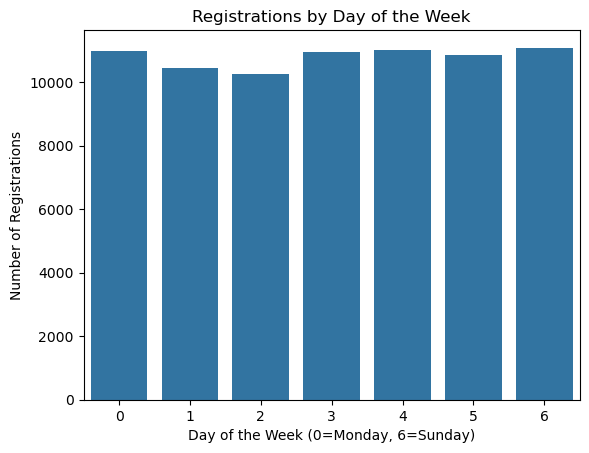

In [27]:
sns.countplot(x='reg_weekday', data = train_ready)
plt.title('Registrations by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Registrations')
plt.show()


In [28]:
hour_labels = [
    '12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM',
    '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM',
    '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM',
    '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'
]

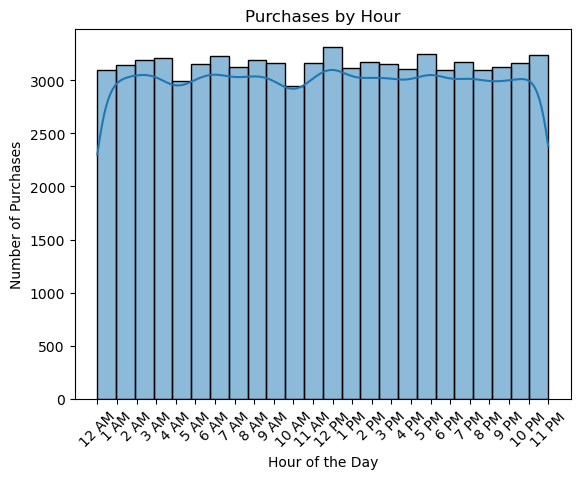

In [29]:
sns.histplot(train_ready['purchase_hour'], bins=24, kde=True)
plt.title('Purchases by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Purchases')
plt.xticks(ticks=range(0, 24), labels=hour_labels, rotation=45)
plt.show()

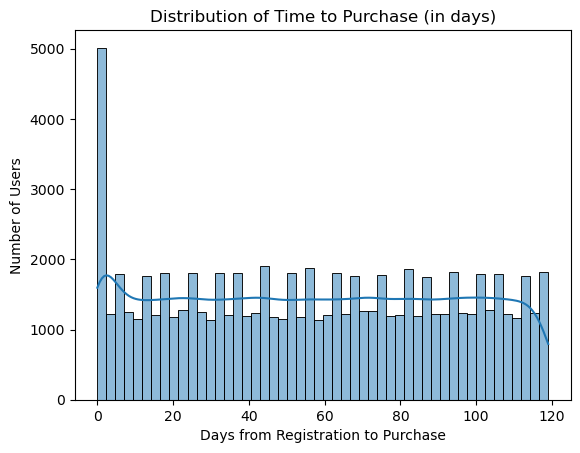

In [30]:
sns.histplot(train_ready['time_to_purchase_days'], bins=50, kde=True)
plt.title('Distribution of Time to Purchase (in days)')
plt.xlabel('Days from Registration to Purchase')
plt.ylabel('Number of Users')
plt.show()

In [31]:
train_ready['ip_address'] = train_ready['ip_address'].astype('int64')
ip['ip_lower_bound'] = ip['ip_lower_bound'].astype('int64')

In [64]:
ip_sorted = ip.sort_values(by='ip_lower_bound')
train_ready_sorted = train_ready.sort_values(by='ip_address')

merged = pd.merge_asof(
    train_ready,
    ip_sorted,
    left_on='ip_address',
    right_on='ip_lower_bound',
    direction='backward'
)

merged = merged[merged['ip_address'] <= merged['ip_upper_bound']]

ValueError: left keys must be sorted

In [ ]:
merged.head()

In [ ]:
merged[['user_id', 'ip_address', 'country_y']].head()

In [ ]:
fraud_rate = merged.groupby('country_y')['fraud'].mean().reset_index()
fraud_rate_sorted = fraud_rate.sort_values(by='fraud', ascending=False)

In [ ]:
top5 = fraud_rate_sorted.head(5)

pie_labels = list(top5['country_y'])
pie_values = list(top5['fraud'])

In [ ]:
plt.figure(figsize=(6, 8))
colors = sns.color_palette('magma', len(pie_labels))  # optional for consistent color palette

plt.pie(
    pie_values,
    labels=pie_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)

plt.title('Top 5 Countries by Fraud Rate')
plt.axis('equal')
plt.show()

In [ ]:
purchase_sum = merged.groupby('country_y')['total_purchase_value'].sum().reset_index()
top_5 = purchase_sum.sort_values(by='total_purchase_value', ascending=False).head(5)

In [ ]:
plt.figure(figsize=(6, 6))

plt.pie(
    top_5['total_purchase_value'],
    labels=top_5['country_y'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('coolwarm', len(top_5))
)

plt.title('Top 5 Countries by Total Purchase Value')
plt.axis('equal')
plt.show()

# Feature Engineering
---

In [44]:
train_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75556 entries, 0 to 75555
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   user_id                         75556 non-null  int64         
 1   account_registration_time       75556 non-null  datetime64[ns]
 2   purchase_time                   75556 non-null  datetime64[ns]
 3   total_purchase_value            75556 non-null  int64         
 4   device_id                       75556 non-null  object        
 5   age                             75556 non-null  int64         
 6   ip_address                      75556 non-null  int64         
 7   fraud                           75556 non-null  int64         
 8   source_Iklan                    75556 non-null  float64       
 9   source_Langsung                 75556 non-null  float64       
 10  source_SEO                      75556 non-null  float64       
 11  br

### 1. Age Category

In [55]:
def categorize_age(age):
    if 15 <= age <= 24:
        return 'Young Adults'
    elif 25 <= age <= 44:
        return 'Adults'
    elif 45 <= age <= 59:
        return 'Middle Aged'
    elif 60 <= age <= 74:
        return 'Elderly'
    elif 75 <= age <= 90:
        return 'Old Age'
    elif age > 90:
        return 'Very Old'
    else:
        return 'Other'

train_ready['age_category'] = train_ready['age'].apply(categorize_age)
print(train_ready['age_category'].value_counts())


age_category
Adults          54386
Young Adults    13313
Middle Aged      7657
Elderly           200
Name: count, dtype: int64


### 2. Quick Purchase

Define if a user make a purchase within one hour of registration. Since fraudsters often create accounts and transacts immediately

In [68]:
# 1. Time-based features

def extract_time_features(df_in):
    df = df_in.copy()
    # Purchase within 1 hour of registration
    df_in['quick_purchase'] = (df_in['time_to_purchase_hours'] < 1).astype(int)
    return df_in

train_ready = extract_time_features(train_ready)
print(train_ready['quick_purchase'].value_counts())


quick_purchase
0    72278
1     3278
Name: count, dtype: int64
fraud
0    69530
1     6026
Name: count, dtype: int64


### 3. Fraud probability
percentage of fraud in each country.

In [60]:
# fraud probability per country
fraud_rate_by_country = train_ready.groupby('country')['fraud'].mean().to_dict()
train_ready['fraud_rate_by_country'] = train_ready['country'].map(fraud_rate_by_country)

threshold_high = train_ready['fraud_rate_by_country'].quantile(0.95)  
threshold_low = train_ready['fraud_rate_by_country'].quantile(0.05)   

def categorize_fraud_risk(rate):
    if rate >= threshold_high:
        return 'High Risk'
    elif rate <= threshold_low:
        return 'Low Risk'
    else:
        return 'Medium Risk'

train_ready['fraud_risk_category'] = train_ready['fraud_rate_by_country'].apply(categorize_fraud_risk)
print(train_ready['fraud_risk_category'].value_counts())


fraud_risk_category
Medium Risk    66844
High Risk       4830
Low Risk        3882
Name: count, dtype: int64


In [70]:
fraud_risk_list = train_ready[['country', 'fraud_risk_category']].drop_duplicates().values.tolist()
for country, risk in fraud_risk_list:
    print(f"Country: {country}, Fraud Risk Category: {risk}")


Country: China, Fraud Risk Category: Medium Risk
Country: Unknown, Fraud Risk Category: Medium Risk
Country: United States, Fraud Risk Category: Medium Risk
Country: Germany, Fraud Risk Category: Medium Risk
Country: Philippines, Fraud Risk Category: Low Risk
Country: Chile, Fraud Risk Category: High Risk
Country: Korea Republic of, Fraud Risk Category: Medium Risk
Country: European Union, Fraud Risk Category: Medium Risk
Country: Spain, Fraud Risk Category: Medium Risk
Country: United Kingdom, Fraud Risk Category: Medium Risk
Country: Ireland, Fraud Risk Category: High Risk
Country: Canada, Fraud Risk Category: High Risk
Country: France, Fraud Risk Category: Medium Risk
Country: Japan, Fraud Risk Category: Medium Risk
Country: Viet Nam, Fraud Risk Category: Medium Risk
Country: Netherlands, Fraud Risk Category: Medium Risk
Country: Turkey, Fraud Risk Category: Medium Risk
Country: Ukraine, Fraud Risk Category: High Risk
Country: Brazil, Fraud Risk Category: Medium Risk
Country: Russia

### 4. High Value Transaction

If a transaction is unusually high compared to other transactions

In [66]:
train_ready['high_value_purchase'] = (train_ready['total_purchase_value'] > train_ready['total_purchase_value'].quantile(0.95)).astype(int)

print(train_ready['high_value_purchase'].value_counts())


high_value_purchase
0    71797
1     3759
Name: count, dtype: int64


# Modelling
---

In [ ]:
# assignment selanjutnya